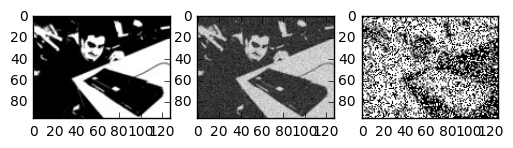

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread
def add_gaussian_noise(im,prop,varSigma):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im)
    im2[index] = im2[index] + e[index]
    return im2
def add_saltnpeppar_noise(im,prop):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]
    return im2
# proportion of pixels to alter
prop = 0.7
varSigma = 0.1
im = imread("../images/manan_grey_resize.jpg")
im = im/255
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(im,cmap='gray')
im2 = add_gaussian_noise(im,prop,varSigma)
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')
im2 = add_saltnpeppar_noise(im,prop)
ax3 = fig.add_subplot(133)
ax3.imshow(im2,cmap='gray')

In [3]:
def neighbours(i,j,M,N,size=4):
    if size==4:
        if (i==0 and j==0):
            n=[(0,1), (1,0)]
        elif i==0 and j==N-1:
            n=[(0,N-2), (1,N-1)]
        elif i==M-1 and j==0:
            n=[(M-1,1), (M-2,0)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2), (M-2,N-1)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        else:
            n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        return n
    if size==8:
        print('Not yet implemented\n')
        #expand this to include diagonal elements
        return -1
    
print(im2.shape)
print(im2.item((34, 123)))
print(im2.item((36, 123)))
print(im2.item((33, 45)))

def likeli(image, imPoint, guess):
    if(image(imPoint) == 1 and guess == 1 or image(imPoint) == 0 and guess == -1):
        return 0.9
    return 0.1

def heightWidth(image):
    #width is the bigger one, the second one
    return image.shape[0], image.shape[1]
    
def E_noOuterSum(image, point):
    expoSum = 0
    M, N = heightWidth(image)
    i, j = point[0], point[1]
    neighbourList = neighbours(i, j, M, N, size=4)
    for neighbour in neighbourList:
        expoSum += (image.item(neighbour) * image.item(point))
    val = np.exp(expoSum)
    return val

def E0(image):
    expoSum = 0
    M, N = heightWidth(image)
    for i in range(M):
        for j in range(N):
            neighbourList = neighbours(i, j, M, N, size=4)
            for neighbour in neighbourList:
                expoSum += (image.item(neighbour) * image.item((i, j)))
    return expoSum

print(E0(im2))
    
def prob(image, point, guess):
    #p(x, y) = 1/Z_1 * Prod_{i=1}^{N} (exp{L_i(x_i)} * 1/Z_0 * exp{Sum_{j in Neighbours(i)} (w_ij * x_i * x_j)})
    #separate the above into terms
    #ignoring likelihood part for now???
    p = 0
    Z0 = 1
    Z1 = 1
    H, W = heightWidth(image)
    for i in range(H):
        for j in range(W):
            p = p * (likeli(image, point, guess) * 1/Z0 * E_noOuterSum(image, point))
    p = p * 1/Z1
    return p
    
def bookEnergy(image, xImage, point):
    #last term
    height, width = heightWidth(image)
    finalSumPos = 0
    finalSumNeg = 0
    for m in range(height):
        for n in range(width):
            if ((m, n) == point):
                finalSumPos += image.item((m, n)) * 1
                finalSumNeg += image.item((m, n)) * -1
            else:
                finalSumPos += image.item((m, n)) * xImage.item((m, n))
                finalSumNeg += image.item((m, n)) * xImage.item((m, n))
    middleSumPos = 0
    middleSumNeg = 0
    for m in range(height):
        for n in range(width):
            neighbourList = neighbours(m, n, height, width, size=4)
            for neighbour in neighbourList:
                if ((m, n) == point):
                    middleSumPos += 1 * xImage.item(neighbour)
                    middleSumNeg += -1 * xImage.item(neighbour)
                else:
                    middleSumPos += xImage.item((m, n)) * xImage.item(neighbour)
                    middleSumNeg += xImage.item((m, n)) * xImage.item(neighbour)
    totalSumPos = finalSumPos + middleSumPos
    totalSumNeg = finalSumNeg + middleSumNeg
    return totalSumPos/10000, totalSumNeg/10000
    
def jointProb(image, xImage, point):
    Z = 1
    posEnergy, negEnergy = bookEnergy(image, xImage, point)
    posVal = 1/Z * np.exp(posEnergy)
    negVal = 1/Z * np.exp(negEnergy)
    return posVal, negVal

print(bookEnergy(im2, im2, (34, 123)))
print(jointProb(im2, im2, (34, 123)))
    
def ICM(image):
    #set all the x variables to be = y variables
    #i.e. all the latent variables initialised as the image output
    H, W = heightWidth(image)
    X = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            if (image.item((i, j)) == 1):
                np.put(X, (i, j), 1)
            elif (image.item((i, j)) == 0):
                np.put(X, (i, j), -1)
                
    print("initialised X i.e. latent image")
    #loop up to a fixed number of times
    #loop through the image and consider the probabilities
    #if the probability of the point being 1 is greater than the probability of the point being -1
    #update the value of the point to be so
    #otherwise, do the opposite
    #flag for if we make a change
    #if through one loop we make no changes
    #break out of the iteration loop
    for iterations in range(15):
        flag = False
        for i in range(H):
            for j in range(W):
                #need to amend prob func to compare prob = 1 and prob = -1
#                 if(prob(image, (i, j), 1) > prob(image, (i, j), -1)):
#                     return None
                probPos, probNeg = jointProb(image, X, (i, j))
                if(probPos > probNeg):
                    if(X.item((i, j)) == -1):
                        flag = True
                        np.put(X, (i, j), 1)
                else:
                    if(X.item((i, j)) == 1):
                        flag = True
                        np.put(X, (i, j), -1)
        if(flag == False):
            break
        print("one iteration of ICM done")
    print("YO WE OUT HERE", iterations)
    return X

imFIXED = ICM(im2)
fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(imFIXED,cmap='gray')
ax2 = fig.add_subplot(122)
ax2.imshow(im2,cmap='gray')
plt.show()

(96, 128)
1.0
1.0
0.0
17439.385836216232
(2.4142632848903536, 2.4138632848903536)
(11.181529720530444, 11.177058003045351)
initialised X i.e. latent image


KeyboardInterrupt: 